<a href="https://colab.research.google.com/github/smlra-kjsce/DL-in-NLP-101/blob/master/RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#RNN Implementation


##Data Preprocessing

In [0]:
!wget http://cmshare.eea.europa.eu/s/6WZZ8dBECmER2EF/download

--2020-03-06 16:37:28--  http://cmshare.eea.europa.eu/s/6WZZ8dBECmER2EF/download
Resolving cmshare.eea.europa.eu (cmshare.eea.europa.eu)... 87.54.7.179
Connecting to cmshare.eea.europa.eu (cmshare.eea.europa.eu)|87.54.7.179|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cmshare.eea.europa.eu/s/6WZZ8dBECmER2EF/download [following]
--2020-03-06 16:37:35--  https://cmshare.eea.europa.eu/s/6WZZ8dBECmER2EF/download
Connecting to cmshare.eea.europa.eu (cmshare.eea.europa.eu)|87.54.7.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103636023 (99M) [application/zip]
Saving to: ‘download’

download            100%[===================>]  98.83M  10.5MB/s    in 11s     

2020-03-06 16:37:48 (8.69 MB/s) - ‘download’ saved [103636023/103636023]



In [0]:
!unzip download

Archive:  download
  inflating: BE_10_2013-2015_aggregated_timeseries.csv  
  inflating: BE_10_2013-2015_timeseries.csv  
  inflating: BE_1_2013-2015_aggregated_timeseries.csv  
  inflating: BE_1_2013-2015_timeseries.csv  
  inflating: BE_2013-2015_metadata.csv  
  inflating: BE_20_2013-2015_aggregated_timeseries.csv  
  inflating: BE_20_2013-2015_timeseries.csv  
  inflating: BE_3012_2013-2015_aggregated_timeseries.csv  
  inflating: BE_3012_2013-2015_timeseries.csv  
  inflating: BE_3014_2013-2015_aggregated_timeseries.csv  
  inflating: BE_3014_2013-2015_timeseries.csv  
  inflating: BE_3015_2013-2015_aggregated_timeseries.csv  
  inflating: BE_3015_2013-2015_timeseries.csv  
  inflating: BE_3018_2013-2015_aggregated_timeseries.csv  
  inflating: BE_3018_2013-2015_timeseries.csv  
  inflating: BE_4013_2013-2015_aggregated_timeseries.csv  
  inflating: BE_4013_2013-2015_timeseries.csv  
  inflating: BE_5012_2013-2015_aggregated_timeseries.csv  
  inflating: BE_5012_2013-2015_timeseri

In [0]:
import pandas as pd
date_vars = ['DatetimeBegin','DatetimeEnd']

df = pd.read_csv('BE_10_2013-2015_timeseries.csv', sep='\t', parse_dates=date_vars, date_parser=pd.to_datetime)
df.head()

,Countrycode,Namespace,AirQualityNetwork,AirQualityStation,AirQualityStationEoICode,SamplingPoint,SamplingProcess,Sample,AirPollutant,AirPollutantCode,AveragingTime,Concentration,UnitOfMeasurement,DatetimeBegin,DatetimeEnd,Validity,Verification
0,BE,BE.CELINE-IRCEL.AQ,NET-Brussels,STA-BETB004,BETB004,SPO-BETB004_00010_100,SPP-BETB004_00010_1,SAM-BETB004_00010,CO,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,0.165,mg/m3,2013-01-01 01:00:00,2013-01-01 02:00:00,1,1
1,BE,BE.CELINE-IRCEL.AQ,NET-Brussels,STA-BETB004,BETB004,SPO-BETB004_00010_100,SPP-BETB004_00010_1,SAM-BETB004_00010,CO,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,0.165,mg/m3,2013-01-01 02:00:00,2013-01-01 03:00:00,1,1
2,BE,BE.CELINE-IRCEL.AQ,NET-Brussels,STA-BETB004,BETB004,SPO-BETB004_00010_100,SPP-BETB004_00010_1,SAM-BETB004_00010,CO,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,0.175,mg/m3,2013-01-01 03:00:00,2013-01-01 04:00:00,1,1
3,BE,BE.CELINE-IRCEL.AQ,NET-Brussels,STA-BETB004,BETB004,SPO-BETB004_00010_100,SPP-BETB004_00010_1,SAM-BETB004_00010,CO,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,0.165,mg/m3,2013-01-01 04:00:00,2013-01-01 05:00:00,1,1
4,BE,BE.CELINE-IRCEL.AQ,NET-Brussels,STA-BETB004,BETB004,SPO-BETB004_00010_100,SPP-BETB004_00010_1,SAM-BETB004_00010,CO,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,0.150,mg/m3,2013-01-01 05:00:00,2013-01-01 06:00:00,1,1


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


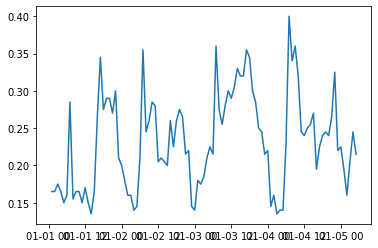

In [0]:
import matplotlib.pyplot as plt

plt.plot(df['DatetimeBegin'][:100],df['Concentration'][:100])
plt.show()

In [0]:
cdf = pd.Series(df['Concentration'].values)
width = 25
lag1 = cdf.shift(1)
lag3 = cdf.shift(width - 1)
window = lag3.rolling(window=width)
means = window.mean()
dataframe = pd.concat([means, lag1, cdf], axis=1)
dataframe.columns = ['mean', 't-1', 't+1']
#dataframe.columns

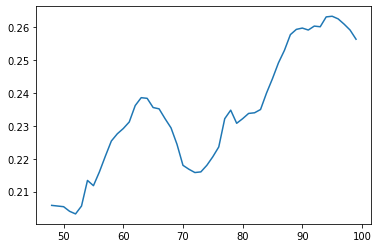

In [0]:
dataframe.head()
plt.plot([i for i in range(len(dataframe['mean']))][0:100],dataframe['mean'][0:100])

In [0]:
import numpy as np
from sklearn import preprocessing

data = np.array(dataframe['mean'][48:])
data = preprocessing.scale(data)
n_inputs=3
data_final = np.column_stack([data[2:], data[1:][1:], data[2:][0:]]) 

In [0]:
data.shape

(640578,)

In [0]:
x = data_final[:-1]
y = data_final.T[0].T[1:]

In [0]:
x.shape, y.shape

((640575, 3), (640575,))

##Modeling

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
import os
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
from numpy.random import randn

In [0]:
args={}
kwargs={}
args['batch_size']=1000
args['test_batch_size']=1000
args['epochs']=10  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=0.01 #Learning rate is how fast it will decend. 
args['momentum']=0.5 #SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).

args['seed']=1 #random seed
args['log_interval']=10
args['cuda']=False

In [0]:
data = torch.from_numpy(x)
target = torch.from_numpy(y)

In [0]:
class RNN(nn.Module):
  def __init__(self):
    super(RNN, self).__init__()
    self.computing_h = nn.Linear(4, 2)
    self.computing_y = nn.Linear(4, 1)
    self.final_output = nn.Linear(1, 1)

  def forward(self, x_current, h_prev, y_prev):
        self.x_current = x_current
        self.h_prev = h_prev
        self.y_prev = y_prev
        self.combined = torch.cat([self.x_current.float(),self.h_prev[0].float(),self.y_prev[0].float()], axis=0).unsqueeze(1)
        self.h_new = F.tanh(self.computing_h(self.combined.T))
        self.y_new = F.tanh(self.computing_y(torch.cat([self.x_current.float(),self.h_new[0].float(),self.y_prev[0].float()], axis=0)))
        self.output = F.relu(self.final_output(self.y_new))
        return self.h_new, self.output
 

Now, with the help of gradient descent we calculate the errors in weights, then correct them and subsequently compute the final weights.
This is done with the help of the loss function. This loss function is the cross entropy loss which is given by L=-ln(p) = -ln(softmax(p))

In [0]:
def train(epoch):
    model.train()
    optimizer = optim.Adam(model.parameters())
    y_new = 0
    global data
    global target
    for epoch in range(1,epoch+1):
      if args['cuda']:
        data, target = data.cuda(), target.cuda()
        #Variables in Pytorch are differenciable. 
      optimizer.zero_grad()
      for i,k in zip(data,target):
        x, y_final = Variable(i), Variable(k)
        h_new = torch.zeros(1,2)
        y_new = torch.zeros(1,1)
        #This will zero out the gradients for this batch. 
        for j in range(3):
          h_new, output = model(x[j].unsqueeze(0), h_new, y_new)
          # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
          loss = torch.mean((output-target)**2)
          # print(loss)
          #dloss/dx for every Variable 
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        #Print out the loss periodically. 
        if epoch % 1 == 0:
          print('Epoch: {}/{}.............'.format(epoch, 10), end=' ')
          print("Loss: {:.4f}".format(loss.item()))

We have,
y = Why​*h​ + by  
With Gradient descent we need to calculate the derivative of the loss function with respect to all the 5 weights involved. ​

In [0]:
model = RNN()
train(10)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 1/10............. Loss: 1.1339
Epoch: 1/10............. Loss: 1.1308
Epoch: 1/10............. Loss: 1.1283
Epoch: 1/10............. Loss: 1.1287
Epoch: 1/10............. Loss: 1.1343
Epoch: 1/10............. Loss: 1.1310
Epoch: 1/10............. Loss: 1.1332
Epoch: 1/10............. Loss: 1.1361
Epoch: 1/10............. Loss: 1.1389
Epoch: 1/10............. Loss: 1.1394
Epoch: 1/10............. Loss: 1.1392
Epoch: 1/10............. Loss: 1.1394
Epoch: 1/10............. Loss: 1.1429
Epoch: 1/10............. Loss: 1.1436
Epoch: 1/10............. Loss: 1.1415
Epoch: 1/10............. Loss: 1.1365
Epoch: 1/10............. Loss: 1.1341
Epoch: 1/10............. Loss: 1.1290
Epoch: 1/10............. Loss: 1.1242
Epoch: 1/10............. Loss: 1.1172
Epoch: 1/10............. Loss: 1.1091
Epoch: 1/10............. Loss: 1.1061
Epoch: 1/10............. Loss: 1.1032
Epoch: 1/10............. Loss: 1.1015
Epoch: 1/10............. Loss: 1.1014
Epoch: 1/10............. Loss: 1.1019
Epoch: 1/10.

KeyboardInterrupt: ignored

In [0]:
t  = torch.cat([model.x_current.float(),model.h_prev[0].float(),model.y_prev[0].float()], axis=0)
t

In [0]:
torch.cat([model.x_current.float(),model.h_new.float(),model.y_prev[0].float()], axis=0)

In [0]:
model.h_new[0].shape

In [0]:
torch.cat([self.x_current.float(),self.h_prev[0].float(),self.y_prev[0].float()], axis=0).shape

In [0]:
model.eval()
d = torch.Tensor([43,44,45])
h_new=torch.Tensor([0,0])
y_new=torch.Tensor([0])
for j in range(3):
  h_new, output = model(d[j].unsqueeze(0), h_new, y_new)
          # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
  print(output)

RuntimeError: ignored

In [0]:
model.x_current.shape

torch.Size([])